In [4]:
import torch
from torch import nn

# Create a convolutional neural network
class DigitRecognizerMNISTV3(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_3 = DigitRecognizerMNISTV3(input_shape=1,
    hidden_units=10,
    output_shape=10).to("cpu")
model_3

DigitRecognizerMNISTV3(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [5]:
import torch

    # Create a new instance of FashionMNISTModelV3 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
MODEL_SAVE_PATH = "models/03_pytorch_computer_vision_model_3.pth"
loaded_model_3 = DigitRecognizerMNISTV3(input_shape=1,
                                    hidden_units=10, # try changing this to 128 and seeing what happens
                                    output_shape=10)

# Load in the saved state_dict()
loaded_model_3.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_3 = loaded_model_3.to("cpu")

ValueError: Could not save to JPEG for display

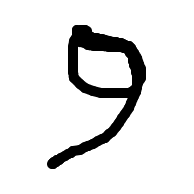

In [38]:
from PIL import Image

def crop_transparency(image_path):
    img = Image.open(image_path)
    img = img.convert("RGBA")

    datas = img.getdata()

    newData = []
    for item in datas:
        if item[0] > 200:
            newData.append((255, 255, 0, 0))
        else:
            newData.append(item)

    img.putdata(newData)

    # Get the bounding box of the non-transparent area
    bbox = img.getbbox()

    # Crop the image to the contents of the bounding box
    img_cropped = img.crop(bbox)

    # Calculate width and height of the cropped image
    width, height = img_cropped.size

    # Determine the size of the square to be the larger of the width and height
    square_size = max(width, height) + 84 # Adding 4 to account for the 2px padding on each side

    # Create a new image of the square size, filled with transparent pixels
    img_square = Image.new('RGBA', (square_size, square_size), (0, 0, 0, 0))

    # Calculate the position to paste the cropped image into the square image
    paste_pos = ((square_size - width) // 2, (square_size - height) // 2)

    # Paste the cropped image into the square image
    img_square.paste(img_cropped, paste_pos)

    # Save the padded square image
    img_square.save("image_cropped_square.png")

    return img_square
crop_transparency("number-9.jpeg")

In [39]:
from PIL import Image, ImageOps

im = Image.open('image_cropped_square.png').convert('RGBA')
white_bg = Image.new('RGBA', im.size, 'WHITE')
    # Paste the image onto the white background
white_bg.paste(im, (0, 0), im)
    # Convert the image to RGB
rgb_img = white_bg.convert('RGB')
im_invert = ImageOps.invert(rgb_img)
im_invert.save('number-9-invert.jpg')

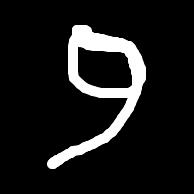

In [40]:
from PIL import Image
prediction_image = Image.open('number-9-invert.jpg')
prediction_image

In [41]:
from torchvision.transforms import ToTensor, Resize, Grayscale, Compose

transforms = Compose([
    Resize((28, 28)),
    ToTensor(),
])

transformed_prediction_image = transforms(prediction_image)
transformed_prediction_image.shape, transformed_prediction_image

(torch.Size([3, 28, 28]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]))

In [42]:
transformed_shaped_prediction_image = transformed_prediction_image[0].unsqueeze(0)
transformed_shaped_prediction_image.shape

torch.Size([1, 28, 28])

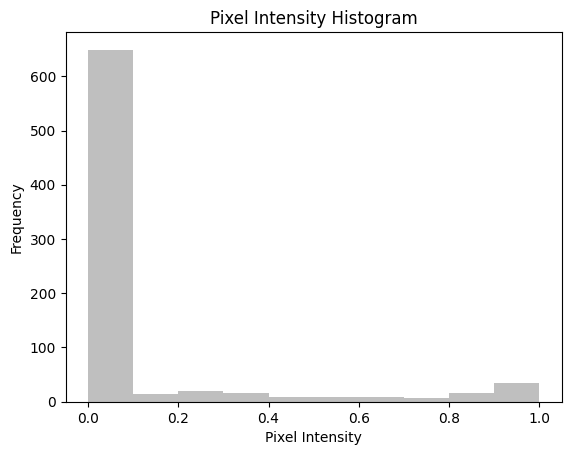

In [43]:
import matplotlib.pyplot as plt

flatten_image = nn.Flatten()
_prediction_image = flatten_image(transformed_shaped_prediction_image)

hist, bin_edges, number_of_x_values= plt.hist(_prediction_image, bins=10, color='gray', alpha=0.5)
plt.title('Pixel Intensity Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

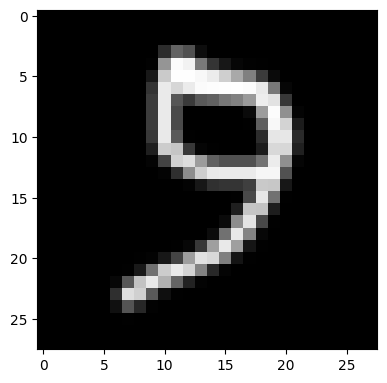

In [44]:
plt.figure(figsize=(10,15))
plt.subplot(321); plt.imshow(transformed_shaped_prediction_image.squeeze(),cmap='gray')

In [45]:
import numpy as np
def threshold_image(im,th):
    thresholded_im = np.zeros(im.shape)
    thresholded_im[im >= th] = 1
    return thresholded_im

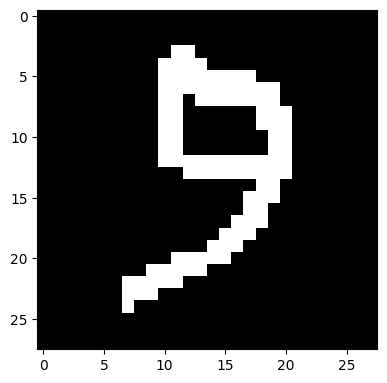

In [46]:
_thresh = threshold_image(transformed_shaped_prediction_image, 0.261)
plt.figure(figsize=(10,15))
plt.subplot(321); plt.imshow(_thresh.squeeze(),cmap='gray')

In [47]:
import torch
import torch.nn.functional as F

_thresh_tensor = torch.from_numpy(_thresh)
last_prediction = transformed_shaped_prediction_image.unsqueeze(0).float()  # Convert to float
output = loaded_model_3(last_prediction)
_, predicted_class = torch.max(output, 1)
print('Predicted class:', predicted_class.item())
output

probabilities = F.softmax(output, dim=1)
predicted_class_probability = probabilities[0, predicted_class.item()].item()

print(f'Probability of predicted class:{predicted_class_probability*100:.6f}%'), output

Predicted class: 3
Probability of predicted class:61.972350%


(None,
 tensor([[-13.9388,  -0.3903,   2.6957,  14.8663,   0.2392,  -3.7947, -26.4269,
            5.7910,   8.7450,  14.3742]], grad_fn=<AddmmBackward0>))